In [4]:
from astroquery.vizier import Vizier
from astropy.coordinates import Angle, SkyCoord
import astropy.coordinates as coord
from astropy import units as u
import math
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import dbscan
from sklearn.cluster import DBSCAN
from sklearn.datasets import *
from astropy.table import Table
import numpy as np
import hdbscan
import pandas as pd
import astropy.coordinates as coord
import seaborn as sns 
color_palette = sns.color_palette("plasma")


In [5]:
# --- Plot Parameters ---- 
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"] = 100
plt.rc('font', family = 'serif', serif = 'cmr10') 
plt.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': True,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            })
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
colour_arrays = ['red', 'blue', 'green', 'crimson', 'lime']

In [6]:
Vizier.ROW_LIMIT = -1
datafile = (Vizier.query_region(SkyCoord.from_name('NGC2355'),
                                 catalog='I/345/gaia2',
                                 radius=10*u.arcmin, 
                                column_filters={'e_Gmag': '<0.01'}))[0].to_pandas()

datafile

print(datafile['e_Gmag'].max())
print(len(datafile))

0.01
1784


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Library/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:58: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For no

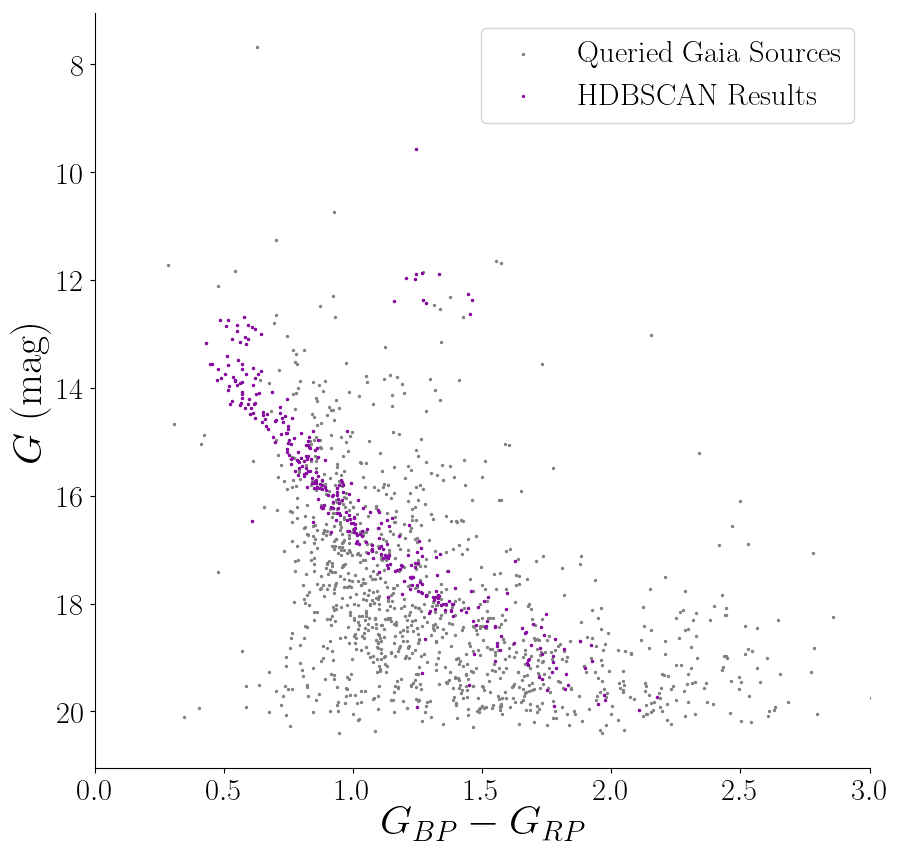

In [7]:
datafile['BPRP'] = datafile['BPmag'] - datafile['RPmag']
data = datafile[(datafile['Plx'] > 0)] # - ensures that there is parallax data for a given entry. 

df = data[["pmRA", "pmDE", "Plx"]]
df = df.to_numpy().astype("float32", copy = False)

stscaler_df = StandardScaler().fit(df)
df_ = stscaler_df.transform(df)
clus_size = 3*df_.shape[1]


clusterer = hdbscan.HDBSCAN(clus_size).fit(df_)

data['clus'] = clusterer.labels_
data['mem_prob'] = clusterer.probabilities_

result_hdbscan = data[data['clus'] >= 0].reset_index(drop=True)
c = result_hdbscan['clus'].value_counts()
n_max = c.index[np.argmax(c)]
result = data[data['clus'] == n_max]

plt.figure(figsize=(10, 10))
plt.scatter(data['BPRP'], data['Gmag'], color = 'grey', s=2., label="Queried Gaia Sources")
plt.scatter(result['BPRP'], result['Gmag'], color= color_palette[1], s=2., label="HDBSCAN Results")

plt.xlabel(r'$G_{BP}-G_{RP}$')
plt.ylabel(r'$G$ (mag)')

plt.xlim(0., 3.)
plt.gca().invert_yaxis()
plt.legend()
plt.savefig('plots/gaia_plot_example.pdf')
plt.show()

results_to_print = result[['RA_ICRS', 'DE_ICRS', 'e_RA_ICRS', 'e_DE_ICRS', 'mem_prob']]
results_to_print.to_csv('gaia_cluster_populations/NGC2355.csv')
